Activate the project

In [1]:
using Pkg
Pkg.activate(".")

  Activating environment at `~/repos/kp-lflm-group/src/KPpack/Project.toml`


# Load the package KPpack

In [2]:
using KPpack

# Create a KP model

In [3]:
using Symbolics, LinearAlgebra
using PyCall, PyPlot

In [4]:
#read Hamiltonian created in createHam.ipynb 
dirHam="/home/martinez/repos/kp-lflm-group/Models_Hamiltonian/";name="kane"

Htot=KPpack.readHamiltonian(dirHam,name)

strK=["k_x","k_y","k_z"];
Emomentum=KPpack.setMomentum(strK);
HVar=KPpack.getVar(Htot);

In [5]:
real(Htot)

8×8 Matrix{Num}:
  E_g + VBO + c*(1 + 2F)*(k_x^2 + k_y^2 + k_z^2)  …                         0
 0                                                                          0.333333Δ
 0                                                                          0
 0                                                                          0
 0                                                                          0
 0                                                …     -c*k_x*k_z*(6g_3 + (-E_p) / E_g)
 0                                                      -c*k_y*k_z*(6g_3 + (-E_p) / E_g)
 0                                                   VBO - c*(g_1 + 4g_2 + (-E_p) / E_g)*(k_z^2) - c*(g_1 - 2g_2)*(k_x^2 + k_y^2)

In [6]:
var=Emomentum[3] 
H0,H1,H2=KPpack.createKm(Htot,var);


In [7]:
real(H2)

8×8 Matrix{Num}:
 c*(1 + 2F)*(k_x^2 + k_y^2) - c*(1 + 2F)*(1 + k_x^2 + k_y^2)  …       0
        0                                                             0
        0                                                             0
        0                                                             0
        0                                                             0
        0                                                     …       0
        0                                                             0
        0                                                        -((c*(E_p - E_g*g_1 - 4E_g*g_2)) / E_g)

## test the bulk calculation

In [8]:
material="GaAs"; Temp=0; soc=true;
tipo="KaneII";
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp)
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

1.519

In [9]:
kmax= 1.4; Nt=100; consth=0.038; const2=0.19
Ktot,Etot=KPpack.calcBandBulk(mm,kmax,Nt,Htot,Emomentum,consth,const2)
#++++++++++++++++++++++++

EDOS, aDOS = KPpack.DOS(-2,2.2,0.01,Etot,0.04);

# Plot band diagram

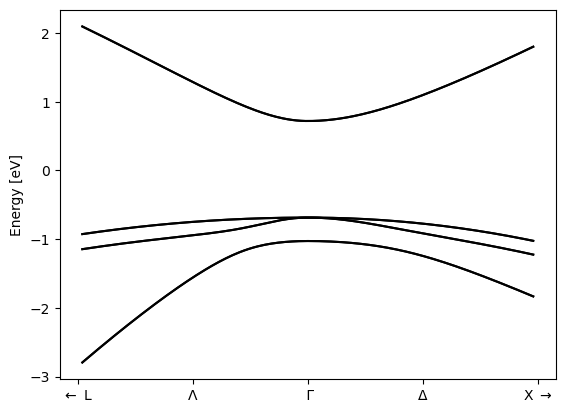

In [10]:
KPpack.PlotBands(Etot,Ktot);

# Plot DOS

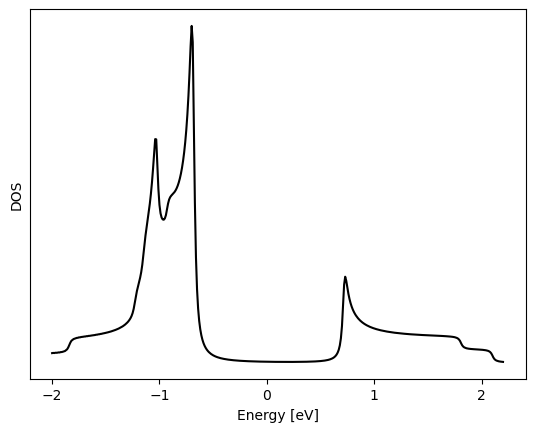

In [11]:
KPpack.PlotDOS(EDOS,aDOS);

# Make a structure

In [12]:
structure=["AlGaAs_1.0" "20";
    "AlGaAs_0.15" "10";
    "GaAs" "6";
    "AlGaAs_0.15" "10";
    "AlGaAs_1.0" "20";]

#structure=["AlGaAs_0.2" "10";
#    "GaAs" "3";
#    "AlGaAs_0.2" "10";]

Npts,layer,nlayer=KPpack.setStructure(structure,0.2)

X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp);


# Plot structure

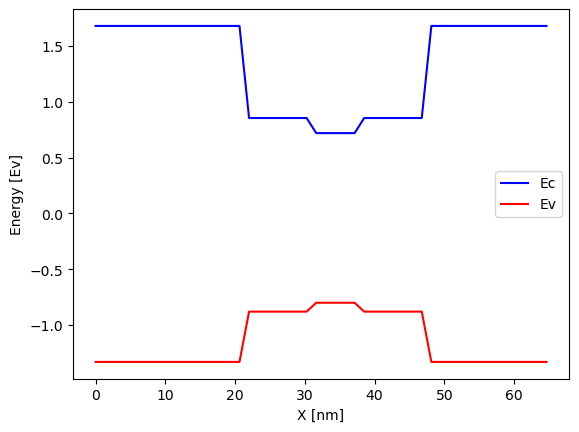

In [13]:
kind="both"
KPpack.plotProf(mlayer,X,kind);

## find eigenvalues solving for K=0

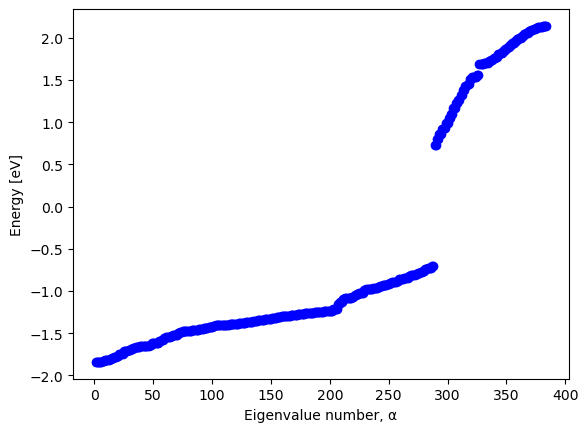

  5.935075 seconds (8.51 M allocations: 519.753 MiB, 5.18% gc time, 90.57% compilation time)


In [14]:
c=0.038; cps=0.19; dx=X[2]-X[1]; pb=true

@time Eqw0, EVqw0=KPpack.EigSolQW(mlayer,Npts,H0,H1,H2,c,cps,dx,Emomentum,pb);
KPpack.PloteigvQW(Npts,Eqw0);

# QW Band Structure Calculation

In [15]:
kmax= 1.2; Nt=100; 
nc=4; nv=2*nc+2
sV,sC,pos=KPpack.eigenValQW(real(Eqw0))

pl=1; pm=1;
@time Ecq11,Evq11,Kqw11 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,H0,H1,H2,nc,nv,c,cps,sV,sC,Emomentum,pb);

pl=1; pm=0;
@time Ecq10,Evq10,Kqw10 =KPpack.DiagQWM(mlayer,kmax+0.1,Nt,dx,pl,pm,Npts,H0,H1,H2,nc,nv,c,cps,sV,sC,Emomentum,pb);

 21.073868 seconds (11.16 M allocations: 2.205 GiB, 2.56% gc time, 22.43% compilation time)
 13.827528 seconds (4.00 M allocations: 1.646 GiB, 2.17% gc time)


## Valence Band 

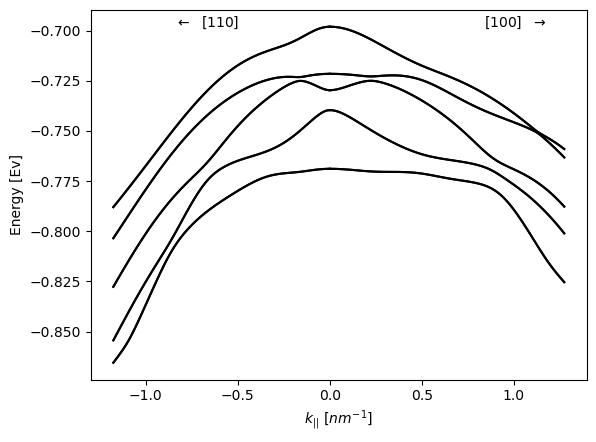

In [16]:
option="complete_V"; poslab=sV
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

## Conduction Band

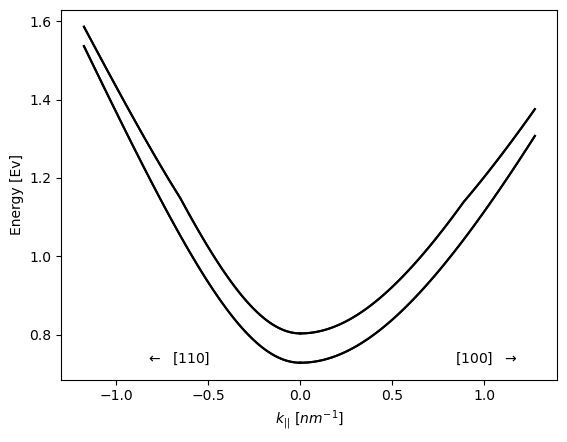

In [17]:
option="complete_C"; poslab=sC
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

# DOS QW

## DOS Valence Band

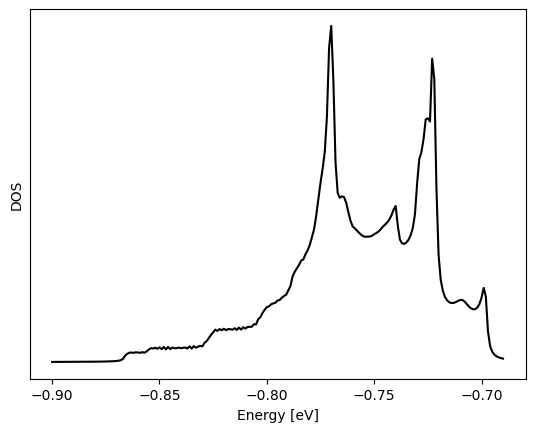

In [18]:
Evqw= vcat(Evq11,Evq10);
EDOSv, aDOSv = KPpack.DOS(-0.9,-0.69,0.001,Evqw,2e-3);
KPpack.PlotDOS(EDOSv,aDOSv);

## DOS Conduction Band

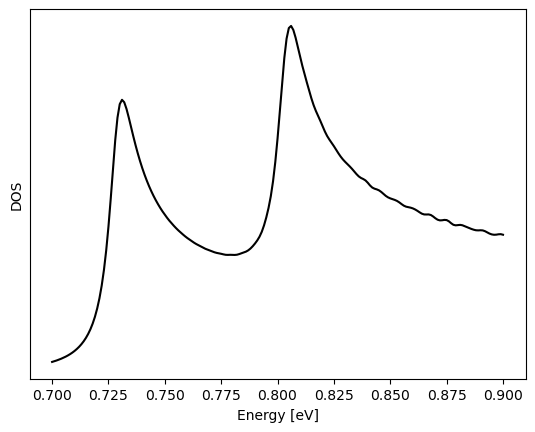

In [19]:
Evqw= vcat(Ecq11,Ecq10);
EDOSc, aDOSc = KPpack.DOS(0.7,0.9,0.001,Evqw,1e-2);
KPpack.PlotDOS(EDOSc,aDOSc);

In [20]:
kx,ky=0.0,0.0
hns=KPpack.FDHamiltonian(H0,H1,H2,mlayer,kx,ky,dx,c,cps,Npts,Emomentum,pb)

384×384 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 2112 stored entries:
⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓
⠀⠻⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠹⣿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠙⣿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⢿⣷⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢿⣷⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣿⣿⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣿⣿⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⢿⣷⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢿⣷⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⢿⣷⣄⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣿⣿⣄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⣿⣿⣆⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢿⣷⣦⠀
⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛⢿⣷

## =====================================================|

In [21]:
hns-hns'

384×384 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 288 stored entries:
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⢮⡳⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⣮⡻⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠀⠀⢀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠐⢮⡳⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⢮⡳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [22]:
i=20
kx,ky=0.0,0.0

H2Re,H2Im=KPpack.createFuncFD(H2,Emomentum);

H2n=KPpack.evalFuncFD(H2Re,H2Im,mlayer,i,kx,ky,c,cp)
real(H2n)

8×8 Matrix{Float64}:
 0.032072  0.0       0.0       …  0.0       0.0        0.0
 0.0       0.104462  0.0          0.0       0.0        0.0
 0.0       0.0       0.104462     0.0       0.0        0.0
 0.0       0.0       0.0          0.0       0.0        0.0
 0.0       0.0       0.0          0.0       0.0        0.0
 0.0       0.0       0.0       …  0.104462  0.0        0.0
 0.0       0.0       0.0          0.0       0.104462   0.0
 0.0       0.0       0.0          0.0       0.0       -0.00565939

In [23]:
EigH2=eigvals(H2n)

8-element Vector{Float64}:
 -0.005659387174808032
 -0.005659387174808032
  0.032071999999999996
  0.032071999999999996
  0.104462
  0.104462
  0.104462
  0.104462

In [24]:
eigneg=0; eigpos=0

for i in 1:length(EigH2)
    if EigH2[i] <= 0
        eigneg += EigH2[i]
    else
        eigpos += EigH2[i]
    end
end

abs(eigneg/eigpos)

0.02348332410001839

save a file with band structure

In [25]:
# save a file in folder data with a name given by the user
dat=hcat(Ktot,Etot);
name="BandStructure_GaAs_1"
KPpack.writefile(dat,name)

# Symbolic

## create a Finite differences matrices

# ====================================================================================

In [26]:
A,B,C=KPpack.constructMatrixFD(H0,H1,H2);
exclude=["k_x","k_y","k_z","c","cp"]; b1="r"; b2="l"
excS=KPpack.setExcludePar(exclude)
PrH=KPpack.getVar(Htot)
Al,Ar,Bl,Br,Cr,Cl=KPpack.createBmatrizFD(H0,H1,H2,PrH,excS,b1,b2);


In [27]:
mt=real(H2)

8×8 Matrix{Num}:
 c*(1 + 2F)*(k_x^2 + k_y^2) - c*(1 + 2F)*(1 + k_x^2 + k_y^2)  …       0
        0                                                             0
        0                                                             0
        0                                                             0
        0                                                             0
        0                                                     …       0
        0                                                             0
        0                                                        -((c*(E_p - E_g*g_1 - 4E_g*g_2)) / E_g)

In [28]:
simplify(mt[2,2])

c*(1 + k_y^2)*(g_1 - 2g_2) - c*(g_1 - 2g_2)*(k_y^2)

In [29]:
imag(Htot)

8×8 Matrix{Num}:
         0  P*cp*k_x          …         0                 0
 -P*cp*k_x         0                    0                 0
 -P*cp*k_y         0.333333Δ            0                -0.333333Δ
 -P*cp*k_z         0                    0.333333Δ         0
         0         0             P*cp*k_y          P*cp*k_z
         0         0          …         0.333333Δ         0
         0         0                    0                 0
         0         0                    0                 0

# ================================

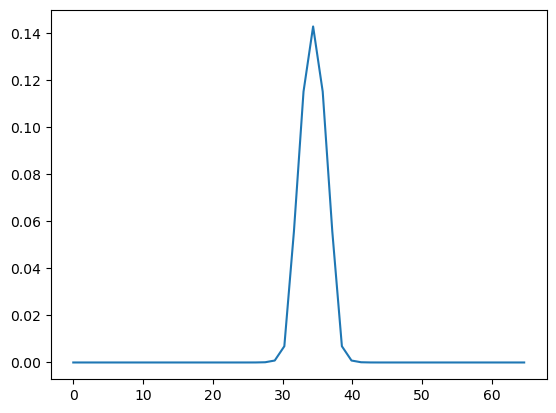

-0.6980759332417967 - 1.7646067252745168e-16im

In [43]:
i=pos-1



Evec=EVqw0[2:8:end,i]

vv=Evec.*transpose(Evec')
#vv=Evec
#lt.xlim(150,250)
plt.plot(X,real(vv))
Eqw0[i]

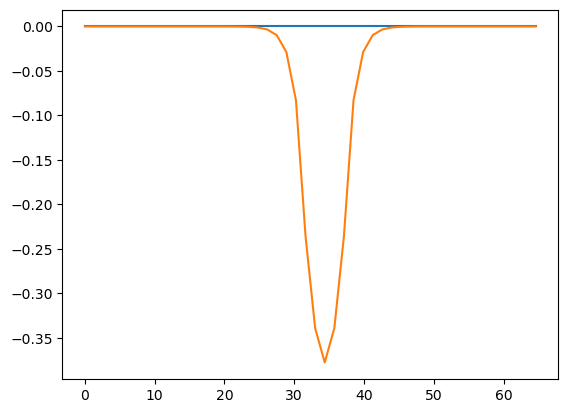

In [44]:
plt.plot(X,real(Evec))
plt.plot(X,imag(Evec));